

# **Notebook: Music Genre Clustering using Spotify Dataset**

**Tugas Praktikum Machine Learning - Unsupervised Learning**

-----

### **Identitas Kelompok**

  * **Lab:** Pembelajaran Mesin E2
  * **Anggota 1:**
      * Nama: [Isi Nama Anggota 1]
      * NIM: [Isi NIM Anggota 1]
  * **Anggota 2:**
      * Nama: Syafiq Abiyyu Taqi
      * NIM: 24060123120012

-----

## **1. Deskripsi Dataset**

Dataset yang digunakan adalah **Spotify Tracks Dataset** (biasanya tersedia di Kaggle atau sumber publik). Dataset ini berisi fitur audio dari ribuan lagu yang diambil menggunakan Spotify Web API.

Fitur utama yang akan digunakan untuk clustering meliputi:

  * **Audio Features:** `danceability`, `energy`, `loudness`, `speechiness`, `acousticness`, `instrumentalness`, `liveness`, `valence`, `tempo`.
  * **Metadata:** `track_name`, `artists`, `album_name`, `track_genre`.

**Tujuan:** Mengelompokkan lagu-lagu ke dalam beberapa klaster berdasarkan kemiripan fitur audionya untuk menemukan pola genre atau *mood* yang tersembunyi.

-----

## **2. Import Library & Load Data**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Konfigurasi Plot
sns.set_style("whitegrid")
%matplotlib inline

# Load Dataset (Sesuaikan path file jika perlu)


# Asumsi nama file adalah dataset.csv sesuai referensi
try:
    # Install dependencies as needed:
    # pip install kagglehub[pandas-datasets]
    import kagglehub
    from kagglehub import KaggleDatasetAdapter

    # Set the path to the file you'd like to load
    file_path = "dataset.csv"

    # Load the latest version
    df = kagglehub.load_dataset(
      KaggleDatasetAdapter.PANDAS,
      "maharshipandya/-spotify-tracks-dataset",
      file_path,
      # Provide any additional arguments like
      # sql_query or pandas_kwargs. See the
      # documenation for more information:
      # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
    )
    print("Data berhasil dimuat!")
except FileNotFoundError:
    print("File tidak ditemukan. Pastikan file dataset.csv ada di direktori yang sama.")

# Tampilkan 5 baris pertama
print("First 5 records:", df.head())

/tmp/ipython-input-3209238048.py:31: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the '-spotify-tracks-dataset' dataset.
Data berhasil dimuat!
First 5 records:    Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost 

-----

## **3. Simple EDA (Exploratory Data Analysis)**

Langkah ini bertujuan untuk memahami struktur data, mengecek nilai yang hilang, duplikat, dan korelasi antar fitur.

In [ ]:
# Cek Info Data
df.info()

# Cek Duplikasi
print(f"\nJumlah data duplikat: {df.duplicated().sum()}")

# Statistik Deskriptif
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,56999.500000,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,32909.109681,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28499.750000,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,56999.500000,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,85499.250000,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


### **Visualisasi Korelasi**

Melihat hubungan antar fitur numerik. Ini penting untuk mengetahui fitur mana yang mungkin redundan atau saling menguatkan.

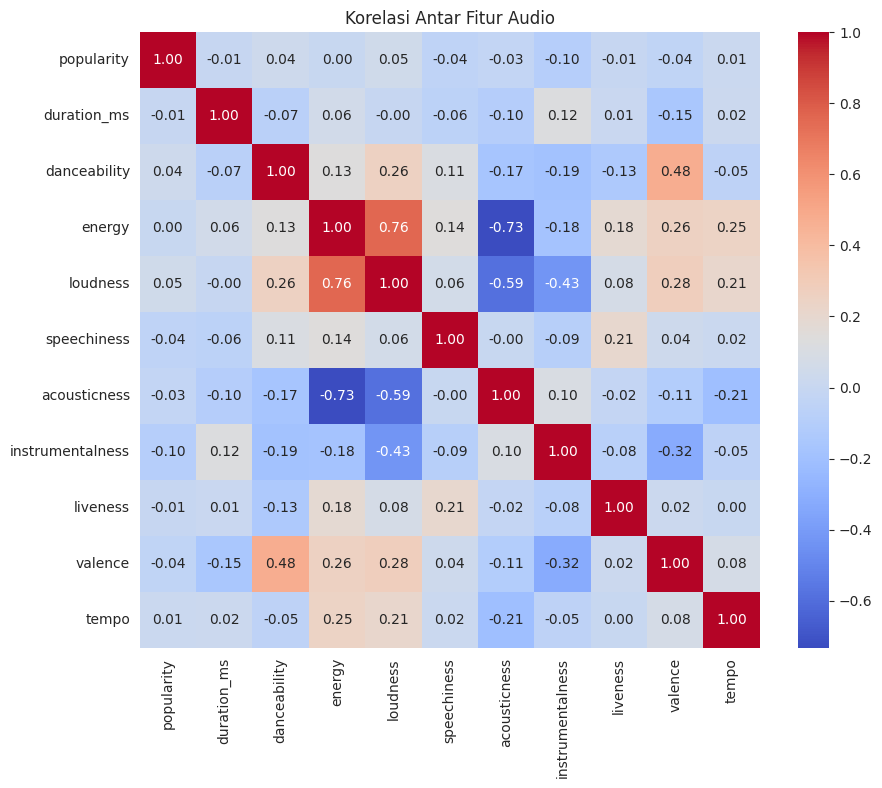

In [ ]:
# Fitur numerik yang relevan untuk audio
num_cols = ['popularity', 'duration_ms', 'danceability', 'energy',
            'loudness', 'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo']

plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi Antar Fitur Audio')
plt.show()

-----

## **4. Preprocessing**

Langkah ini meliputi pembersihan data (menghapus duplikat/null), penyederhanaan fitur (Genre Mapping), dan penskalaan data (Scaling).

### **4.1 Cleaning Data**

Menghapus duplikat dan nilai kosong agar model tidak bias.

In [ ]:
# Hapus Duplikat & Null
df_clean = df.drop_duplicates()
df_clean = df_clean.dropna()

# Reset Index
df_clean.reset_index(drop=True, inplace=True)
print(f"Dimensi data setelah cleaning: {df_clean.shape}")

Dimensi data setelah cleaning: (113999, 21)


### **4.2 Feature Engineering (Genre Mapping)**

Karena genre di Spotify sangat banyak dan spesifik, kita akan menyederhanakannya menjadi kategori besar (seperti di notebook referensi) untuk mempermudah analisis klaster nanti.

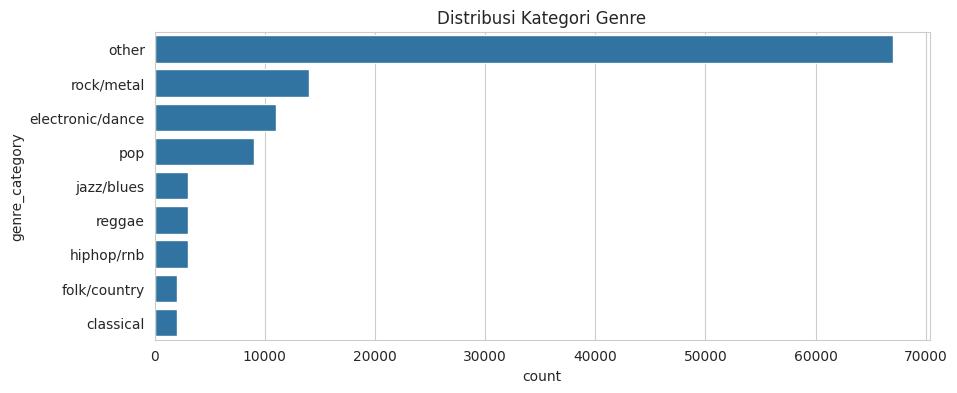

In [ ]:
def map_genre_groups(x):
    if type(x) is str:
        x = x.lower()

    # Mapping sederhana berdasarkan kata kunci
    if 'pop' in x: return 'pop'
    elif 'rock' in x or 'metal' in x or 'grunge' in x: return 'rock/metal'
    elif 'hip' in x or 'hop' in x or 'rap' in x or 'r-n-b' in x: return 'hiphop/rnb'
    elif 'jazz' in x or 'blues' in x or 'soul' in x: return 'jazz/blues'
    elif 'electronic' in x or 'dance' in x or 'techno' in x or 'house' in x: return 'electronic/dance'
    elif 'classic' in x or 'opera' in x: return 'classical'
    elif 'reggae' in x or 'ska' in x: return 'reggae'
    elif 'folk' in x or 'country' in x: return 'folk/country'
    else: return 'other'

# Terapkan mapping
df_clean['genre_category'] = df_clean['track_genre'].apply(map_genre_groups)

# Cek distribusi genre baru
plt.figure(figsize=(10, 4))
sns.countplot(y=df_clean['genre_category'], order=df_clean['genre_category'].value_counts().index)
plt.title('Distribusi Kategori Genre')
plt.show()

### **4.3 Scaling (Standardisasi)**

K-Means menggunakan jarak Euclidean, sehingga fitur dengan skala besar (seperti `duration_ms` atau `loudness`) akan mendominasi. Kita perlu menstandarisasi semua fitur ke skala yang sama (Mean=0, Std=1).

In [ ]:
# Fitur yang akan digunakan untuk clustering
cluster_cols = ['danceability', 'energy', 'loudness', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[cluster_cols])

# Data siap digunakan
print("Data shape after scaling:", X_scaled.shape)

Data shape after scaling: (113999, 9)


-----

## **5. Dimensionality Reduction (PCA) & Feature Selection**

Kita menggunakan **PCA (Principal Component Analysis)** untuk mereduksi dimensi data dari 9 fitur audio menjadi 2 komponen utama.
**Alasan:**

1.  Mengurangi *Curse of Dimensionality*.
2.  Memungkinkan visualisasi klaster dalam plot 2D.

<!-- end list -->

In [ ]:
# Inisialisasi PCA dengan 2 komponen
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Lihat berapa banyak variansi data yang dijelaskan oleh 2 komponen ini
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Information Retained: {sum(pca.explained_variance_ratio_) * 100:.2f}%")

# Buat DataFrame hasil PCA untuk plotting nanti
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

Explained Variance Ratio: [0.31928144 0.15850939]
Total Information Retained: 47.78%


-----

## **6. Modelling Cluster (K-Means)**

Kita akan menggunakan algoritma **K-Means**. Langkah pertama adalah menentukan jumlah klaster optimal ($k$) menggunakan **Elbow Method**.

### **6.1 Menentukan K Optimal (Elbow Method)**

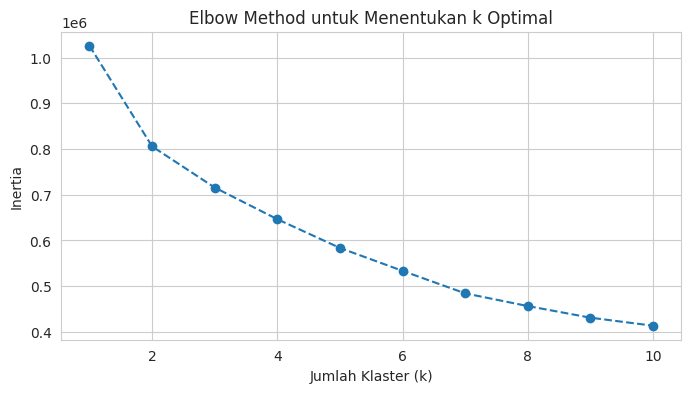

In [ ]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Jumlah Klaster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method untuk Menentukan k Optimal')
plt.show()

### **6.2 Training Model**

Berdasarkan grafik Elbow (biasanya lekukan ada di k=3, 4, atau 5), kita pilih **k=4** (atau sesuaikan dengan hasil plot kamu).

In [ ]:
# Misalkan kita pilih k=4 berdasarkan analisis Elbow
k_optimal = 4

kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Simpan hasil klaster ke dataframe asli dan PCA dataframe
df_clean['cluster'] = clusters
df_pca['cluster'] = clusters

-----

## **7. Post-Clustering Visualization & Analysis**

Tahap ini adalah untuk menginterpretasikan makna dari setiap klaster yang terbentuk.

### **7.1 Visualisasi Klaster (PCA 2D)**

Memvisualisasikan hasil pengelompokan dalam ruang 2D.

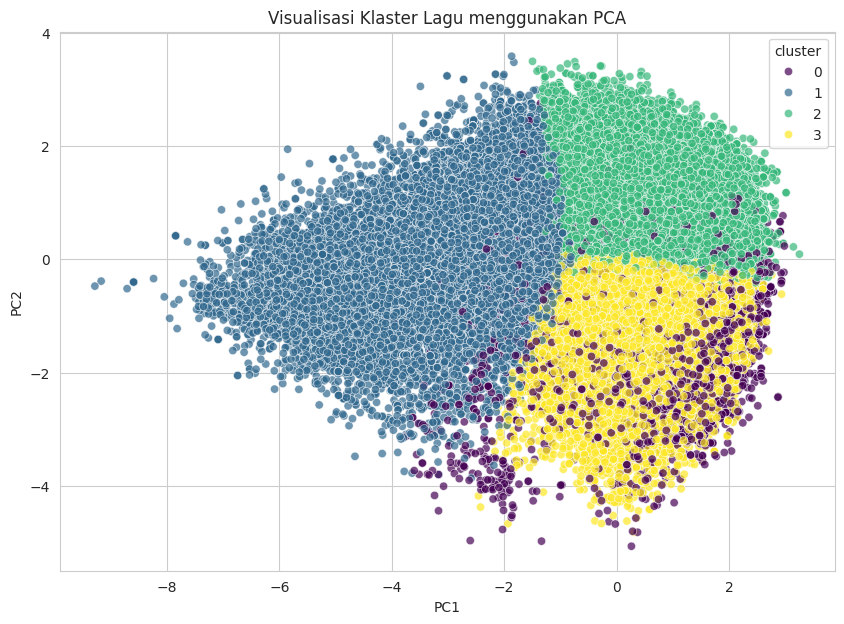

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='viridis', alpha=0.7)
plt.title('Visualisasi Klaster Lagu menggunakan PCA')
plt.show()

### **7.2 Analisis Karakteristik Klaster**

Kita akan melihat rata-rata fitur audio untuk setiap klaster untuk memahami "kepribadian" dari klaster tersebut.

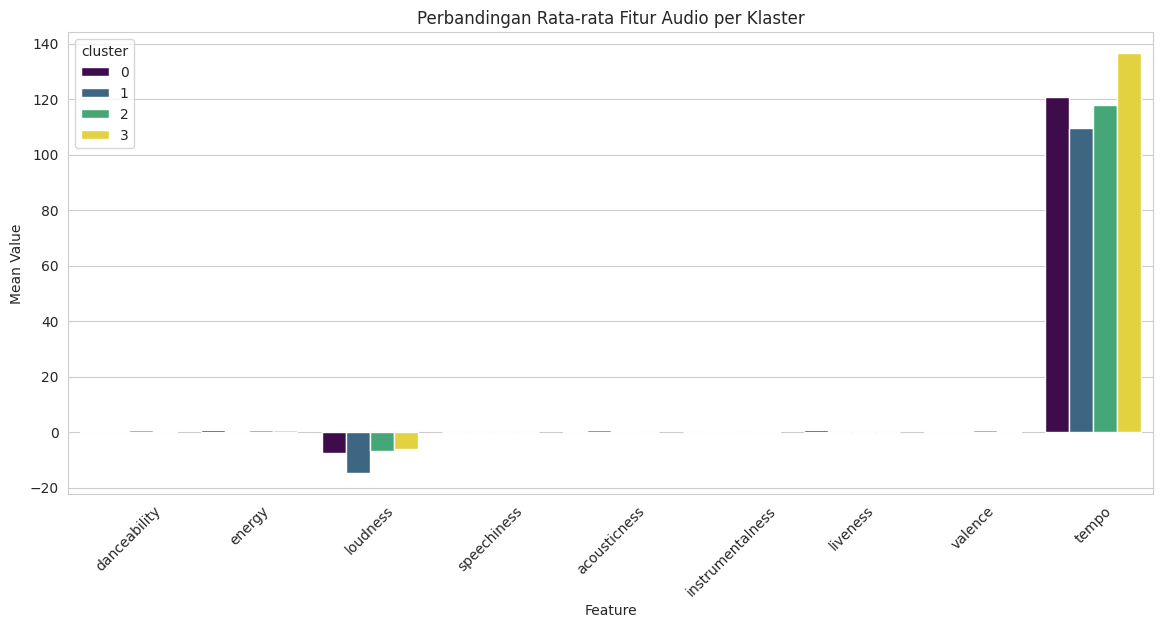

In [ ]:
# Group by cluster dan hitung rata-rata fitur audio
cluster_summary = df_clean.groupby('cluster')[cluster_cols].mean().reset_index()

# Visualisasi menggunakan Bar Plot untuk interpretasi
cluster_melt = pd.melt(cluster_summary, id_vars=['cluster'], var_name='Feature', value_name='Mean Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=cluster_melt, x='Feature', y='Mean Value', hue='cluster', palette='viridis')
plt.title('Perbandingan Rata-rata Fitur Audio per Klaster')
plt.xticks(rotation=45)
plt.show()

### **7.3 Interpretasi Makna Klaster**

*Analisis ini didasarkan pada grafik bar di atas. (Contoh analisis, sesuaikan dengan hasil run notebook kamu)*:

  * **Klaster 0 (Contoh: Energetic/Dance):** Memiliki nilai `energy` dan `danceability` yang tinggi, serta `acousticness` yang rendah. Kemungkinan berisi lagu-lagu Pop, Dance, atau Hip-hop.
  * **Klaster 1 (Contoh: Acoustic/Calm):** Memiliki `acousticness` sangat tinggi dan `energy` rendah. Kemungkinan berisi lagu-lagu Folk, Klasik, atau Balada.
  * **Klaster 2 (Contoh: Instrumental/Focus):** Memiliki `instrumentalness` yang tinggi dan `speechiness` rendah. Cocok untuk lagu latar belajar atau tidur.
  * **Klaster 3 (Contoh: Dark/Heavy):** Memiliki `loudness` tinggi dan `valence` (kebahagiaan) rendah. Mungkin berisi lagu-lagu Rock atau Metal.

<!-- end list -->

In [ ]:
# Melihat contoh lagu di setiap klaster untuk memvalidasi analisis
for c in range(k_optimal):
    print(f"\n--- Contoh Lagu di Klaster {c} ---")
    print(df_clean[df_clean['cluster'] == c][['track_name', 'artists', 'genre_category']].head(5))


--- Contoh Lagu di Klaster 0 ---
               track_name                  artists genre_category
51                透明だった世界            Motohiro Hata          other
73   You're Still The One              Bailey Jehl          other
343      A Month from Now         Rail Yard Ghosts          other
518                 Waves              Canyon City          other
535               Help Me  Sonny Boy Williamson II          other

--- Contoh Lagu di Klaster 1 ---
                   track_name                               artists  \
1            Ghost - Acoustic                          Ben Woodward   
2              To Begin Again                Ingrid Michaelson;ZAYN   
3  Can't Help Falling In Love                          Kina Grannis   
4                     Hold On                      Chord Overstreet   
6               Say Something  A Great Big World;Christina Aguilera   

  genre_category  
1          other  
2          other  
3          other  
4          other  
6          oth

-----

**Kesimpulan:**
Proyek ini berhasil mengelompokkan lagu-lagu Spotify ke dalam [Masukkan Jumlah K] klaster yang berbeda karakteristiknya. PCA membantu memvisualisasikan pemisahan data secara 2 dimensi, dan analisis fitur rata-rata membantu kita memberikan label pada setiap klaster (misalnya: Akustik, Energik, Instrumental).